In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import healpy as hp
from scipy.stats import binned_statistic
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline
import time
import sys
import sqlite3
import json
import glob

In [2]:
# Built on Peter and Lynne's original notebooks:
# https://github.com/rhiannonlynne/notebooks/blob/master/Template%20Generation.ipynb
# https://github.com/yoachim/22_Scratch/blob/main/template_metrics/template_stuff.ipynb

# Set up variables and get the first year of observations

In [3]:
# select the survey simulation
baseline_db = "baseline_v3.0_10yrs.db"
year1_fname = 'first_year_{}.db'.format(baseline_db.split(".db")[0])

# range of nights to investigate (year 1 of survey)
night_min = 0
night_max = 365

In [4]:
# set nside for analysis metric (use higher resolution when removing no-template images later)
nside = 32
# nside = 256
s_hp = maf.HealpixSlicer(nside=nside)

# make a time slicer
nights = np.arange(night_min, night_max+1, 1)
s_t = maf.OneDSlicer(sliceColName="night", bins = nights)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [5]:
# set path for metric output files
# save_dir = "remove_no_template_results_{}".format(nside)
save_dir = "remove_no_template_results_{}_test2".format(nside)

In [6]:
# use the healpix area to find approximate number of healpixels in a single visit
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees
lsst_footprint = 9.6 # square degrees, GET EXACT NUMBER?
n_pix = lsst_footprint/pix_area # number of healpixels within each visit footprint
print("healpixel area = {} square degrees\n number of healpixels in visit = {}".format(pix_area,n_pix))

healpixel area = 3.357174580844667 square degrees
 number of healpixels in visit = 2.8595474464675097


In [7]:
# Set some fraction of visit covered by template required to be analysed
frac = 0.9

In [8]:
# Choose to ignore deep drilling fields 
# This string will be applied to metric sql query and also to the redacted database code
# sqlDD = ''
sqlDD = ' and note not like "%DD%"'

if sqlDD!='':
    save_dir+="_noDD" # change the save directory
    
print(save_dir)

remove_no_template_results_32_test2_noDD


In [9]:
# query or load the database of year 1 observations
if not os.path.isfile(year1_fname): 
    print("get year 1 observations")
    conn = sqlite3.connect(baseline_db)
    df = pd.read_sql('select * from observations;', conn)
    df_year1 = df[df["night"]<=night_max]
    conn.close()

    # open up a connection to a new database
    conn = sqlite3.connect(year1_fname)
    df_year1.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()
    
else:
    conn = sqlite3.connect(year1_fname)
    df_year1 = pd.read_sql('select * from observations;', conn)
    conn.close()

In [10]:
# set up some filenames
opsim_fname = year1_fname
print(opsim_fname)
opsdb = maf.OpsimDatabase(opsim_fname)
runName = os.path.split(opsdb)[-1].replace('.db', '')
print(runName)

first_year_baseline_v3.0_10yrs.db
first_year_baseline_v3.0_10yrs


In [11]:
# template generation timescales to test
tscales = [28,28*4,28*6]

# store the timescale and template generation nights in a dict
template_timescales = {}

for tscale in tscales:
    
    # divide year 1 into chunks of a given template_timescale
    template_nights = np.arange(0,night_max+tscale,tscale)
    template_nights[-1] = night_max # consider only the first year
        
    template_timescales[str(tscale)] = template_nights
    
template_timescales

{'28': array([  0,  28,  56,  84, 112, 140, 168, 196, 224, 252, 280, 308, 336,
        364, 365]),
 '112': array([  0, 112, 224, 336, 365]),
 '168': array([  0, 168, 336, 365])}

# Remove visits without templates using Peter's code

Add Lynne's requirements on image quality when counting number of available images to generate template with.

Peter's code assumes that a template will be generated once, on a given night.

In [12]:
# new base class. We might consider moving this into BaseMetric, or maybe doing this in the slicer instead.
class BaseTemplateMetric(maf.metrics.BaseMetric):
    """Make a new base class that will filter out observation from before we have templates available
    """
    def __init__(self,
                col=None,
                n_visits_for_template=3., # note that this is float
                night_template_min=182,
                mjdCol='observationStartMJD',
                nightCol='night',
                filterCol='filter',
                 seeing_ratio=2.0, m5_range=0.5, 
                 seeingCol='seeingFwhmEff', m5Col='fiveSigmaDepth',
                 **kwargs):
        if col is None:
            col = []
        else:
            col = [col]
        col += [mjdCol, nightCol, filterCol]
        super().__init__(col=col, **kwargs)
        self.n_visits_for_template = n_visits_for_template
        self.night_template_min = night_template_min
        self.mjdCol = mjdCol
        self.nightCol = nightCol
        self.filterCol = filterCol
        
        self.seeingCol = seeingCol
        self.m5Col = m5Col
        self.seeing_ratio = seeing_ratio
        self.m5_range = m5_range
        
        # this snippet (from Lynne nb) is required to set the columns that need to be called when running the metric
        if 'metricName' in kwargs:
            self.metricName = kwargs['metricName']
            del kwargs['metricName']
        else:
            self.metricName = 'BaseTemplateMetric'
        super().__init__(col=[self.mjdCol, self.seeingCol, self.m5Col, self.nightCol, self.filterCol], 
                         metricName=self.metricName, **kwargs)
        
        print("night_template_min = {}, seeing_ratio = {}, m5_range = {}".format(self.night_template_min,self.seeing_ratio,self.m5_range))
        
    def _remove_no_template_visits(self, dataSlice):
        
        dataSlice.sort(order=self.mjdCol)
        
        # add Lynne's seeing requirements
        # Find the best seeing in the first few images
        n_visits = int(self.n_visits_for_template) # number of good images required for template
        bench_seeing = np.min(dataSlice[self.seeingCol][0:n_visits+1])
        bench_m5 = np.max(dataSlice[self.m5Col][0:n_visits+1])
        
        # define the masks for visits meeting the seeing/depth requirements
        seeing_ok = np.where(dataSlice[self.seeingCol]/bench_seeing < self.seeing_ratio, 
                            True, False) 
        m5_ok = np.where(bench_m5 - dataSlice[self.m5Col] < self.m5_range,
                        True, False)
        
        # template images must have been taken before the generation date
        template_time = np.where(dataSlice[self.nightCol] < self.night_template_min,
                        True, False)
        # science images can only be counted after the generation date
        image_time = np.where(dataSlice[self.nightCol] > self.night_template_min,
                        True, False)
        # should use a greater than sign for nights here? Or allow leeway for template generation time?
        
        # Apply the masks to remove images not suitable for templates/science
        # everything starts as true and is switched to false if required
        has_template_indx = np.ones(dataSlice.size, dtype=bool) # science images with templates
        template_img_indx = np.ones(dataSlice.size, dtype=bool) # images used for templates
        
        # define list of images that are suitable for generating templates by removing "bad" visits
        template_img_indx[~(seeing_ok & m5_ok & template_time)] = False
        
        # define list of possible science images, can't have a template before the template construction time
        has_template_indx[~(image_time)] = False
        
#         print(self.night_template_min,len(dataSlice),sum(template_img_indx),sum(has_template_indx))
        
        # look at each dataslice by filter, because template images must be in the same filter
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)[0]
            
            # check if there are is a sufficent number of images for making the templates
            # if not, no science images can be counted in this healpixel until next template time
            if sum(template_img_indx[infilt])<n_visits:
                has_template_indx[infilt] = False
        
#         print(sum(has_template_indx))

        # return the mask of science images with templates
        # By returning mask we can access the science images and the template images
        return has_template_indx


In [13]:

# OK, now let's write a function that takes a bunch of observations in, 
# then cuts out ones that probably don't have template images

# Class that will return all the id's that we think have templates generated
class HasTemplateIndx(BaseTemplateMetric):
    """Return the obIds that probably have templates
    This then allows you to run metrics directly on the visits of the dataslice 
    that had templates and could generate alerts
    """
    def __init__(self, col='observationId', metricDtype="object", **kwargs):
        super().__init__(col=col, metricDtype=metricDtype, **kwargs)
        self.idCol = col
    def run(self, dataSlice, slicePoint=None):
        has_template_indx = self._remove_no_template_visits(dataSlice) # get the mask of science images
        dataSlice = dataSlice[has_template_indx] # apply the mask to the dataSlice
        return dataSlice[self.idCol]

In [14]:

def remove_no_templates(data_in, nside=32, id_col='observationId',
                        night_template_min = 182,
                        template_col = "npix_template", # column name to store fraction of visit covered by template
                        **kwargs):
    """
    This function removes all visits from data_in that had zero template coverage.
    data_in is some chunk of year 1 with visits between times of template generation.
    Visits that had a template for at least one of its constituent healpixels are retained.
    We add a new column that records the number of healpixels with templates within each visit.
    """
    
    slicer = maf.slicers.HealpixSlicer(nside=nside, verbose=False)
    metric = HasTemplateIndx(night_template_min = night_template_min, **kwargs)
    print("night_template_min = {}".format(metric.night_template_min))
    sql=None
    bundle = maf.MetricBundle(metric, slicer, sql)
    mbg = maf.MetricBundleGroup([bundle], None, saveEarly=False,
                                verbose=False)
    mbg.runCurrent(None, simData=data_in)
    
    # we retrieve an array with the id_col (observationId) of every single visit 
    # that had at least one constituent healpixel with a template
    # An id_col value can appear multiple times as there are multiple healpixels within each visit
    all_vals = np.concatenate(bundle.metricValues.data[~bundle.metricValues.mask])

    # we find all unique id_col, these are the visits that had some form of template
    # we count the number of each unique id_col, this is the number of healpixels within the visit that had templates
    valid_ids,count_ids = np.unique(all_vals,return_counts=True)
#     print(valid_ids,count_ids)

    # keep only visits with templates
    indx = np.in1d(data_in[id_col], valid_ids)
    result = data_in[indx]
    ### ALSO KEEP VISITS WHERE TEMPLATE_COL = 0?
    
    # add a column to track number of healpixels with templates within visits 
    # ONLY for visits that had at least one template
    result[template_col] = count_ids
  
    # return the database of visits with templates
    return result

# Run metrics on dataslice directly

In [16]:
class doAllTemplateMetrics(BaseTemplateMetric):
    
    # run all the metrics on dataSlice so that the the removal of visits only occurs once
    
    def __init__(self, col='observationId', **kwargs):
        # ensure all kwargs are passed to teh template class (e.g. night_template_min)
        super().__init__(col=col, **kwargs)
        self.idCol = col
        
    def run(self, dataSlice, slicePoint=None):

        # run the template checking code to create a dataSlice with only the visits with templates
        has_template_indx = self._remove_no_template_visits(dataSlice) # get the mask of science images

        # return a list of both dataSlices, one with science images, one with template images
        return [dataSlice[has_template_indx],dataSlice[~has_template_indx]] # This is stored as metricVal
    
    def reduceCount(self,metricVal):
        # Count the number of visits with templates within each healpix
        x = metricVal[0] # science images
        count = len(x)
        if count==0:
            count = self.badval # set badval to help with metric plotting later
        return count
        
    def reducePairs(self,metricVal):
        # Get the number of pairs available in each healpix
        x = metricVal[0] # science images
        if len(x)==0:
            pairs = self.badval
        else:
            pairs = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName='Pairs').run(x)
        return pairs
    
    def reduceNight(self,metricVal):
        # Get the first night when templates are available
        # note that this should not count beyond the template generation night
        x = metricVal[0] # science images
        if (len(x)==0):
            night = self.badval
        else:
            # if there is at least one healpixel which satisifies templates
            # then we can say that the template was made on at least the template generation night
            night = self.night_template_min                
        return night
    
    ### additional metrics
    # time from first visit
    # date range of all template images
    # date range of first 3 template images
    # N.B. how do these work in our code with distinct generation nights?
    # N.B. there are multiple filters...

Querying table None with constraint filter = "z" and night <= 365 and note not like "%DD%" for columns ['observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA']
Found 38481 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_z_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_z_and_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_z_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_z_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 365 and note not like "%DD%" for columns ['observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA']
Found 14795 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_g_and_night_l

/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_u_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_u_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 365 and note not like "%DD%" for columns ['observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Found 209367 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_HEAL']
Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" and night <= 365 and note not like "%DD%" for columns ['observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA']
Found 47350 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_y_and_night_lt_365_and_note_not_like_DD_HEAL']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_y_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_y_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "r" and night <= 365 and note not like "%DD%" for columns ['observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA']
Found 47662 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_and_night_lt_365_and_note_not_like_DD_HEAL']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_r_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_r_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "i" and night <= 365 and note not like "%DD%" for columns ['observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA']
Found 51215 visits
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_i_and_night_lt_365_and_note_not_like_DD_HEAL']


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/slicers/oneDSlicer.py:108: UserWarning: Warning: this OneDSlicer was already set up once. Re-setting up a OneDSlicer is unpredictable; at the very least, it will change the mapping of the simulated data into the data slices, and may result in poor binsize choices (although these may potentially be ok). A safer choice is to use a separate OneDSlicer for each MetricBundle.
  warnings.warn(warning_msg)
0.0 180.0 -180.0 180.0


Completed metric generation.
Running:  ['first_year_baseline_v3_0_10yrs_nside-32_CountMetric_i_and_night_lt_365_and_note_not_like_DD_ONED', 'first_year_baseline_v3_0_10yrs_nside-32_PairMetric_i_and_night_lt_365_and_note_not_like_DD_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter = "z" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "g" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "u" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "night <= 365 and note not like "%DD%"" constraint now.


/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/plots/spatialPlotters.py:192: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(fignum, figsize=plotDict["figsize"])
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "y" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "r" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = "i" and night <= 365 and note not like "%DD%"" constraint now.


0.0 180.0 -180.0 180.0
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/Users/jrobinson/miniconda3/envs/rubin/lib/python3.9/site-packages/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make inf bins, returning 200
  warnings.warn(


Plotting complete.
58.83270311355591s (0.980545min or 0.016342hrs)


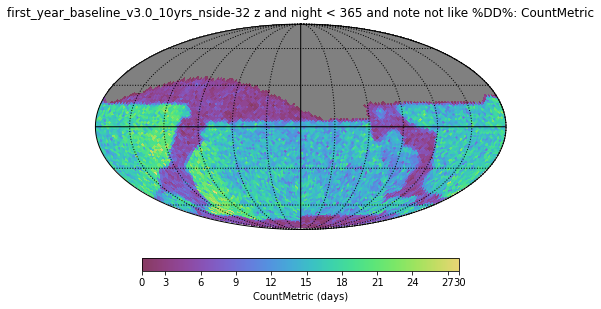

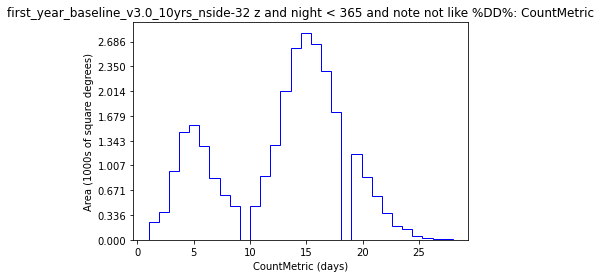

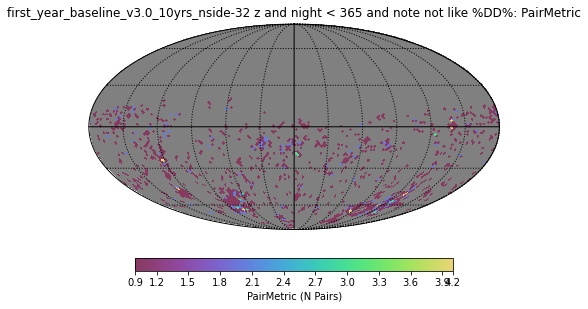

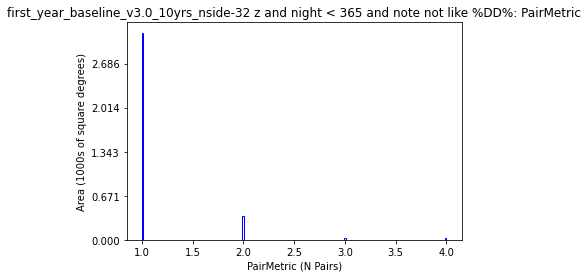

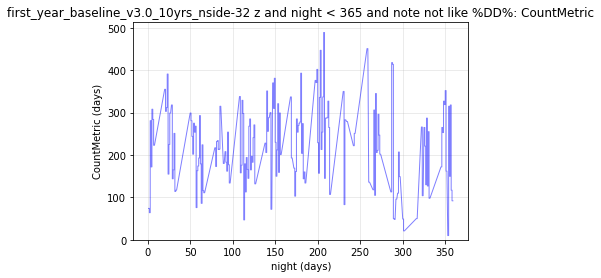

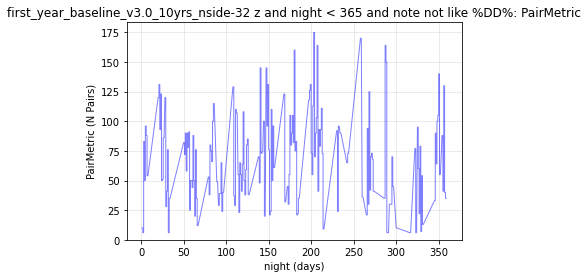

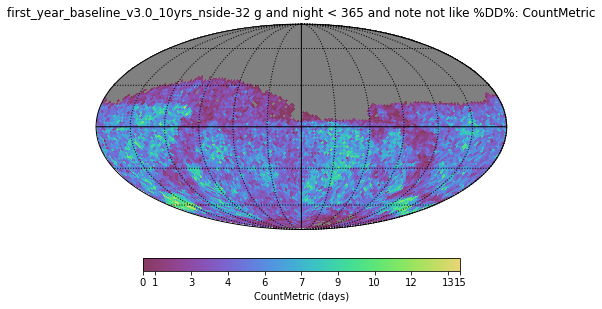

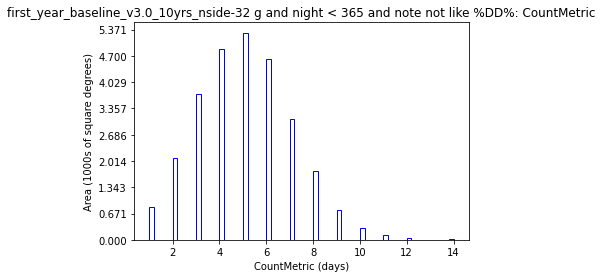

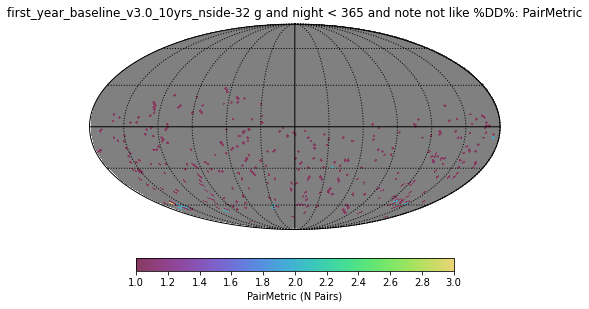

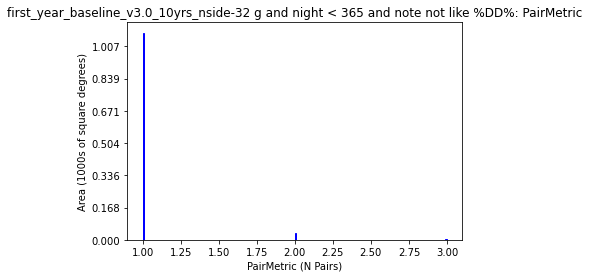

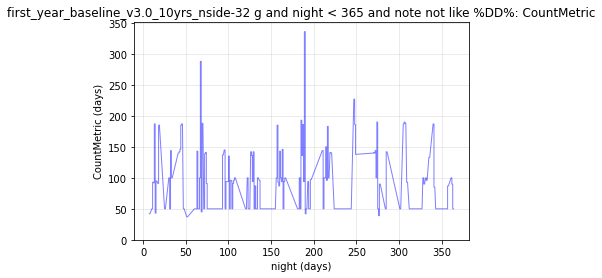

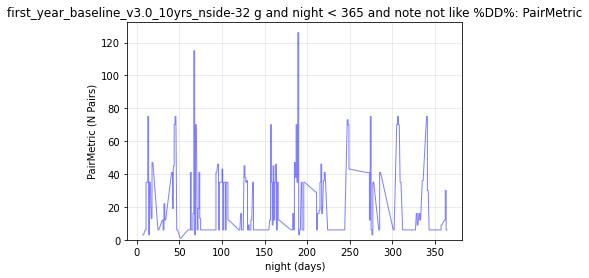

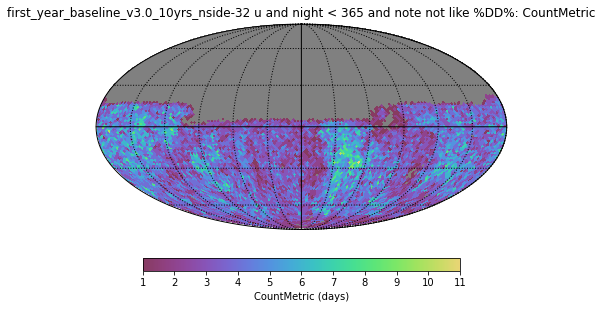

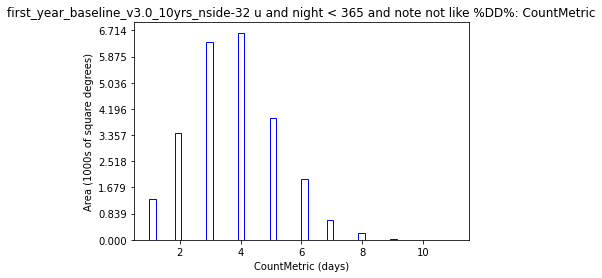

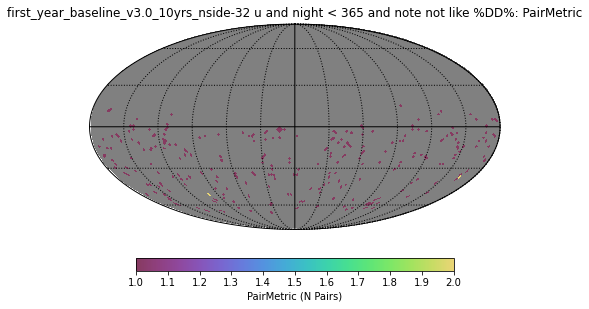

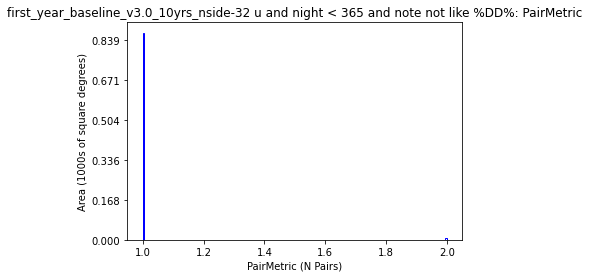

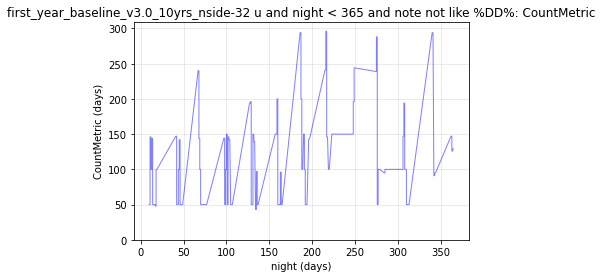

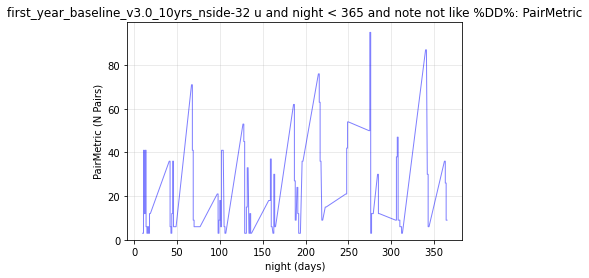

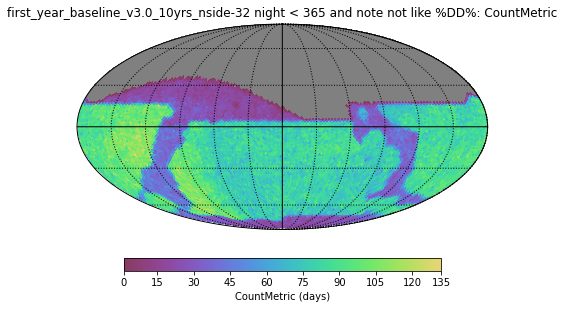

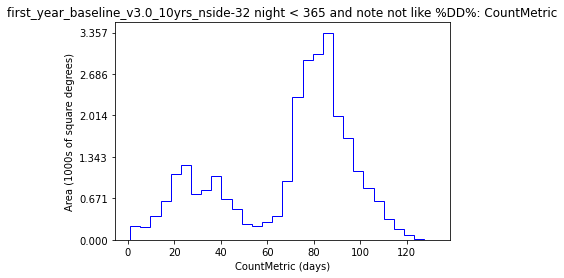

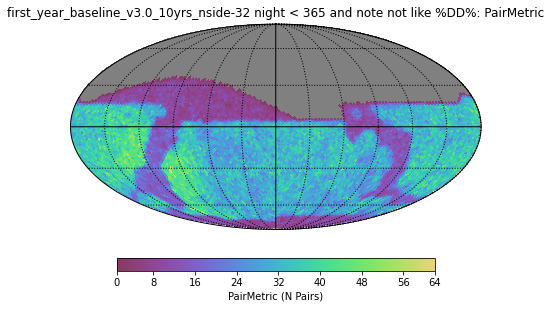

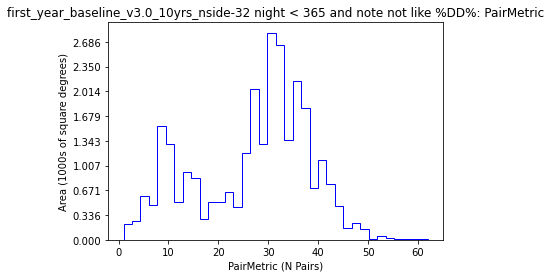

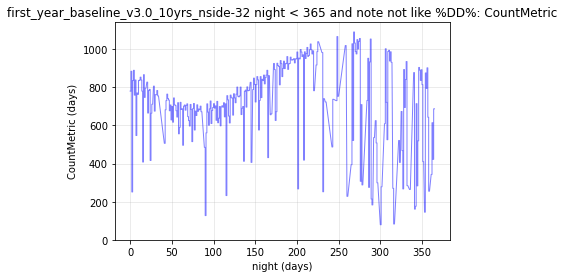

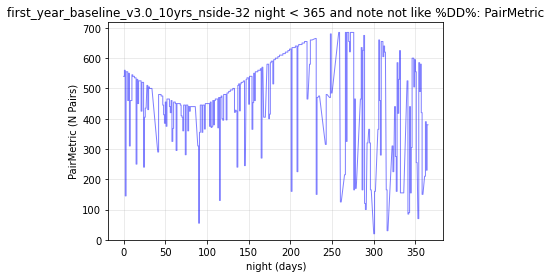

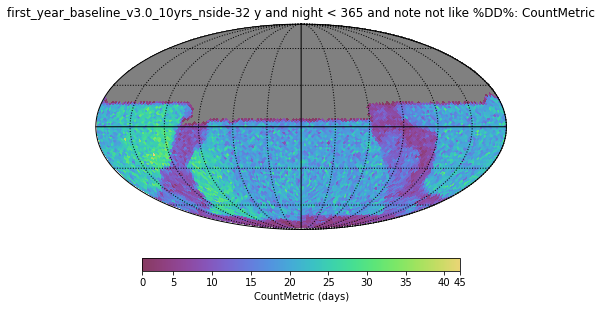

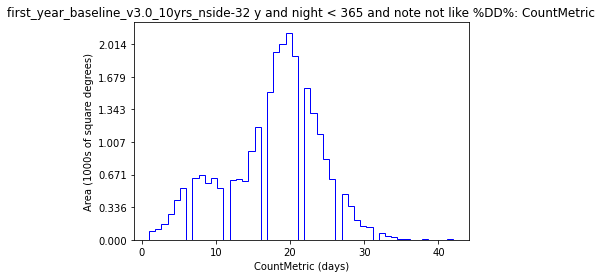

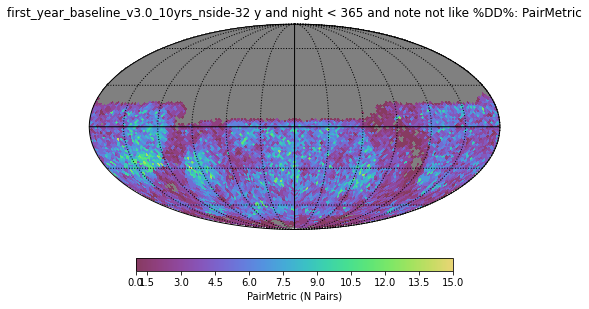

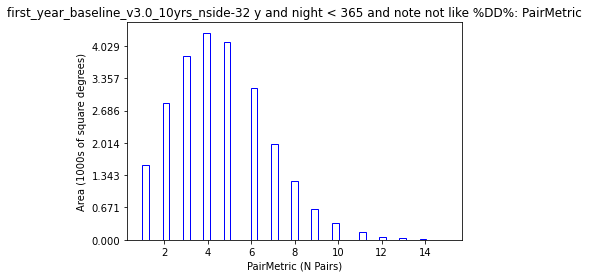

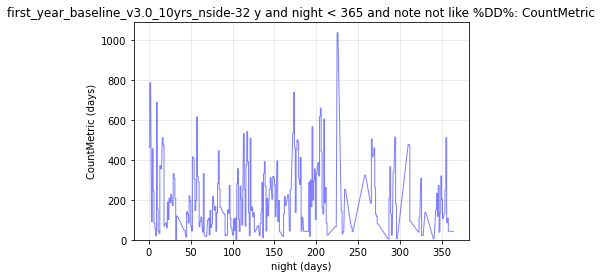

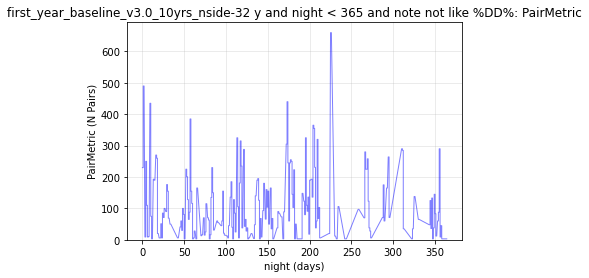

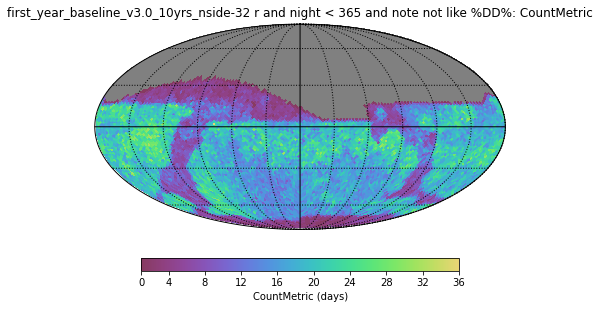

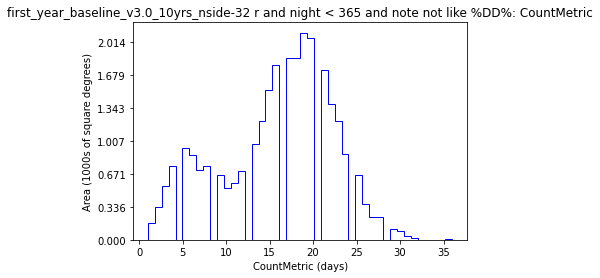

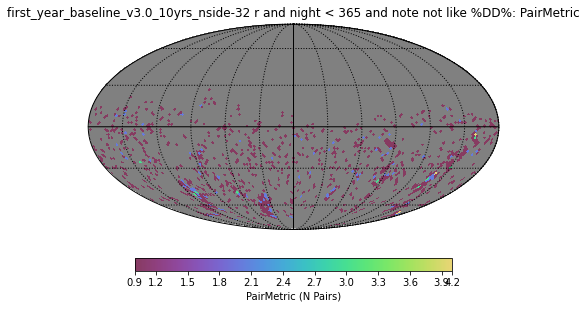

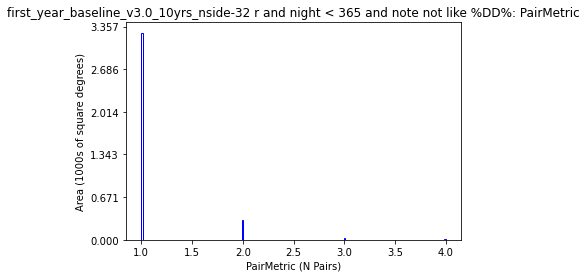

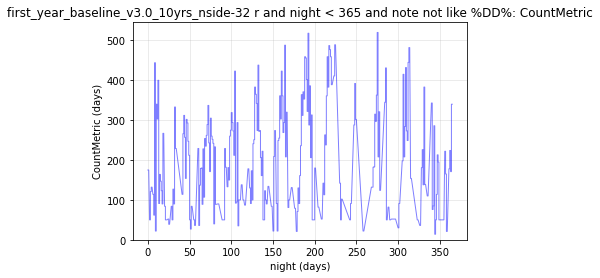

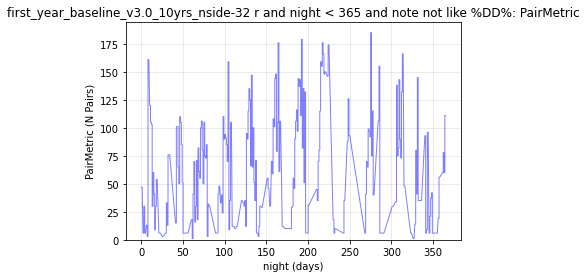

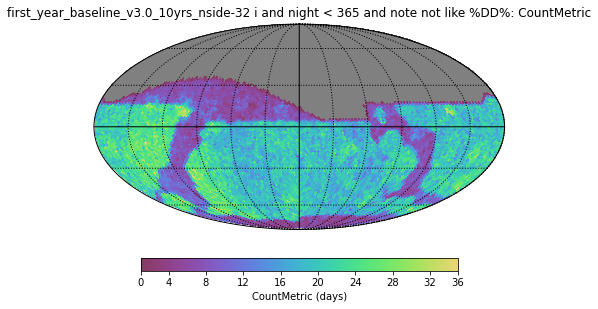

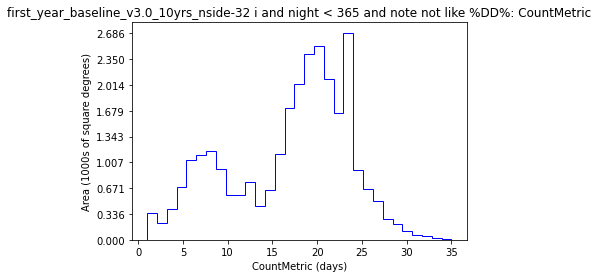

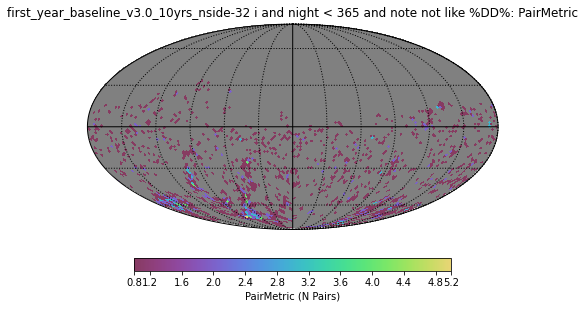

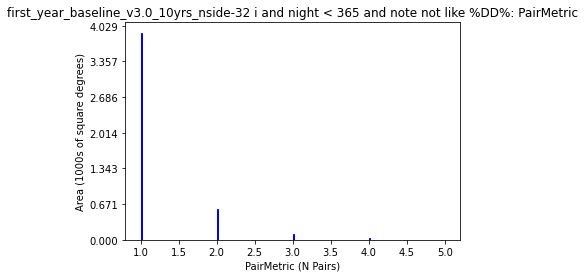

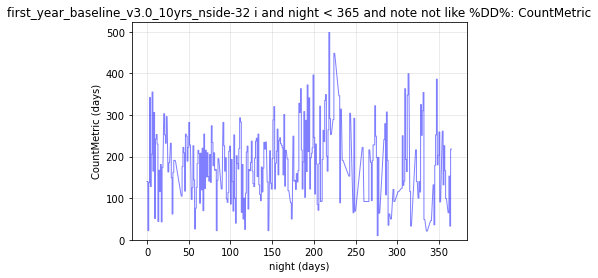

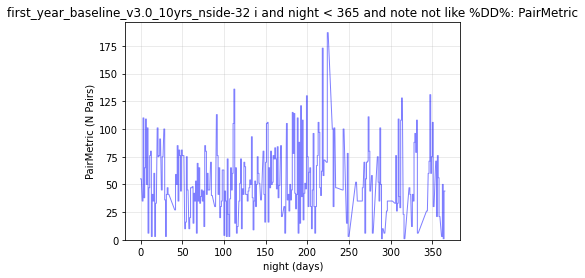

In [17]:
start = time.time()

# Do regular metrics
slicer1 = s_hp # spatial slicer
slicer2 = s_t # time (night) slicer

t_data=night_max

_runName = "{}_nside-{}".format(runName,nside)

bl = []
summary_stats = [maf.MedianMetric()]

for filt in ["all","u","g","r","i","z","y"]:
# for filt in ["all"]:

    if filt=="all":
        sql = 'night <= {}'.format(t_data)+sqlDD
    else:
        sql = 'filter = "{}" and night <= {}'.format(filt,t_data)+sqlDD

    # Run the regular metrics without templates
    metric = maf.CountMetric(col='night', metricName = "CountMetric")
    bl.append(maf.MetricBundle(metric, slicer1, sql, summaryMetrics=summary_stats, runName=_runName))

    metric = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName = "PairMetric")
    bl.append(maf.MetricBundle(metric, slicer1, sql, summaryMetrics=summary_stats, runName=_runName))
    
    # Run the time based metrics
    metric = maf.CountMetric(col='night', metricName = "CountMetric")
    bl.append(maf.MetricBundle(metric, slicer2, sql, summaryMetrics=summary_stats, runName=_runName))
    
    metric = maf.metrics.pairMetric.PairMetric(mjdCol='observationStartMJD', metricName = "PairMetric")
    bl.append(maf.MetricBundle(metric, slicer2, sql, summaryMetrics=summary_stats, runName=_runName))
    
mg = maf.MetricBundleGroup(bl, opsdb, outDir=save_dir)

mg.runAll()
mg.plotAll(closefigs=False)
    
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

In [18]:
# do metrics with templates for a spatial slicer

start = time.time()

slicer = s_hp

for template_timescale in tscales:

    _runName = "{}_tscale-{}_nside-{}".format(runName,template_timescale,nside)

    template_nights = template_timescales[str(template_timescale)]
    
    for i in range(1,len(template_nights)):
        
        t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
        t_template = template_nights[i-1] # this is the last date at which templates were generated
            
        print(template_timescale,t_template,t_data)

        bl = []
        summary_stats = [maf.MedianMetric()]

        for filt in ["all","u","g","r","i","z","y"]:
#         for filt in ["r"]:
#         for filt in ["all"]:

            if filt=="all":
                sql = 'night <= {}'.format(t_data)+sqlDD
            else:
                sql = 'filter = "{}" and night <= {}'.format(filt,t_data)+sqlDD

            # Our new metric that only counts things after templates have been generated
            metric = doAllTemplateMetrics(units='count', metricName = "doAllTemplateMetrics", 
                                             night_template_min = t_template)
            bl.append(maf.MetricBundle(metric, slicer, sql, summaryMetrics=summary_stats, runName=_runName))
            
        mg = maf.MetricBundleGroup(bl, opsdb, outDir=save_dir)

        mg.runAll()
#             mg.plotAll(closefigs=False)
            
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

28 0 28
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
Querying table None with constraint filter = "z" and night <= 28 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 3764 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_z_and_night_lt_28_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 28 and note not like "%DD%" for columns ['fiveSigmaDepth', 'ob

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 84 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 53126 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_night_lt_84_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" and night <= 84 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 13634 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_y_and_night_lt_84_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 140 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 6668 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_140_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 140 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 88795 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_night_lt_140_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
28 140 168
night

Querying table None with constraint filter = "r" and night <= 224 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 35013 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_r_and_night_lt_224_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 224 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 10892 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_224_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "y" and night <= 224 and note not like 

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "r" and night <= 280 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 39229 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_r_and_night_lt_280_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 280 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 12527 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_g_and_night_lt_280_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "z" and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 35629 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_z_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
28 336 364
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 336, seeing_ratio = 2.0, m5_range = 0.5
Querying tab

Querying table None with constraint filter = "r" and night <= 112 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 15009 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_r_and_night_lt_112_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 112 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 69176 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_night_lt_112_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 112 and note not like "%DD%" for columns ['

Found 44815 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_r_and_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 196211 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_night_lt_336_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 336 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 8982 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_u_

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "g" and night <= 168 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 8060 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_g_and_night_lt_168_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter = "u" and night <= 168 and note not like "%DD%" for columns ['fiveSigmaDepth', 'observationStartMJD', 'night', 'fieldDec', 'rotSkyPos', 'fieldRA', 'filter', 'seeingFwhmEff']
Found 4609 visits
Running:  ['first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_u_and_night_lt_168_and_note_not_like_DD_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

Running summary statistics.
Completed.
393.1058042049408s (6.551763min or 0.109196hrs)


# Load the saved template metric data and combine the chunks

In [19]:
start = time.time()

# glob filenames with pattern: runName, metricName
files = glob.glob("{}/*npz".format(save_dir))

# metric_list = ["doAllTemplateMetrics_Count","doAllTemplateMetrics_Pairs","doAllTemplateMetrics_Night",
#               "doAllTemplateMetricsTime_Count","doAllTemplateMetricsTime_Pairs"] # add regular metrics etc

metric_list = ["doAllTemplateMetrics_Count","doAllTemplateMetrics_Pairs","doAllTemplateMetrics_Night"]

# sql_list # to get filters
filters = ["all","u","g","r","i","z","y"]

metric_dict = {}

for template_timescale in tscales:

    _runName = "{}_tscale-{}_nside-{}".format(runName,template_timescale,nside).replace(".","_")
    
    print(_runName)
    
    metric_dict[str(template_timescale)] = {}
            
    for metric in metric_list:
        
        print(metric)
        
        metric_dict[str(template_timescale)][metric] = {}
        
        for filt in filters:

            print(filt)
            
            if filt=="all":
                _files = [x for x in files if (_runName in x) & (metric in x) 
                         & ~(("_u_".format(filt) in x)
                         | ("_g_".format(filt) in x)
                         | ("_r_".format(filt) in x)
                         | ("_i_".format(filt) in x)
                         | ("_z_".format(filt) in x)
                         | ("_y_".format(filt) in x))]                
            else:
                _files = [x for x in files if (_runName in x) & (metric in x) & ("_{}_".format(filt) in x)]
            _files.sort() # sort to ensure files are in numerical order
            print(_files)
            print(len(_files))
            
            if len(_files)==0:
                print("NO FILES?")
                continue

    #     for i in range(1,len(template_nights)):

    #         t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
    #         t_template = template_nights[i-1] # this is the last date at which templates were generated

            metric_bundle = []

            for x in _files:
                metric_bundle.append(maf.MetricBundle.load(x))


    #         # Slice points required for plotting
    #         metric_slice = metric_bundle[0].slicer.slicePoints

            # retrieve all the masked arrays, each value corresponds to the metric value for some slice point
            data = [mb.metricValues.data for mb in metric_bundle]
            mask = [mb.metricValues.mask for mb in metric_bundle]
            metric_data = np.ma.array(data, mask=mask)

            if metric=="doAllTemplateMetrics_Night":
                # find the min of all constituent metrics
                metric_vals = metric_data.min(axis=0)
            else:
                # find the sum of all constituent metrics
                metric_vals = metric_data.sum(axis=0)

            metric_vals.fill_value = np.nan

            metric_dict[str(template_timescale)][metric][filt] = metric_vals

#             break
#         break
        
end = time.time()
dt = end-start
print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))
    
# take the sum or min etc
# make new pretty plots

first_year_baseline_v3_0_10yrs_tscale-28_nside-32
doAllTemplateMetrics_Count
all
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_196_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Count_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllT

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slic

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
doAllTemplateMetrics_Pairs
all
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Pairs_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Pairs_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Pairs_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_ns

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
doAllTemplateMetrics_Night
all
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_140_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAl

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-28_nside-32_doAllTemplateMetrics_Night_r_and_night_lt_112_and_note_not_like_DD_HE

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
first_year_baseline_v3_0_10yrs_tscale-112_nside-32
doAllTemplateMetrics_Count
all
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Count_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Count_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Count_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
u
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Pairs_u_and_night_lt_112_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Pairs_u_and_night_lt_224_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Pairs_u_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-112_nside-32_doAllTemplateMetrics_Pairs_u_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
4
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix

g
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_g_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_g_and_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_g_and_night_lt_365_and_note_not_like_DD_HEAL.npz']
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
r
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Count_r_and_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
doAllTemplateMetrics_Night
all
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_night_lt_168_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_night_lt_336_and_note_not_like_DD_HEAL.npz', 'remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_night_lt_365_and_note_not_like_DD_HEAL.npz']
3
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes
u
['remove_no_template_results_32_test2_noDD/first_year_baseline_v3_0_10yrs_tscale-168_nside-32_doAllTemplateMetrics_Night_u_and_night_lt_168_and_note_not_like_DD_HEAL

In [20]:
for x in metric_dict.keys():
    print(metric_dict[x].keys())
    for y in metric_dict[x].keys():
        print(len(metric_dict[x][y]))

dict_keys(['doAllTemplateMetrics_Count', 'doAllTemplateMetrics_Pairs', 'doAllTemplateMetrics_Night'])
7
7
7
dict_keys(['doAllTemplateMetrics_Count', 'doAllTemplateMetrics_Pairs', 'doAllTemplateMetrics_Night'])
7
7
7
dict_keys(['doAllTemplateMetrics_Count', 'doAllTemplateMetrics_Pairs', 'doAllTemplateMetrics_Night'])
7
7
7


In [21]:
metric_data

masked_array(
  data=[[--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, 168.0, --, --, --, --, --, --, 168.0, 168.0, --, --, --,
         --, --, 168.0, 168.0, 168.0, --, --, --, --, --, --, --, 168.0,
         --, --, --, 168.0, 168.0, 168.0, 168.0, --, --, --, --, 168.0,
         --, --, 168.0, 168.0, 168.0, --, --, 168.0, --, 168.0, 168.0,
         --, 

In [22]:
# metric_dict["28"]["doAllTemplateMetricsTime_Count"]["all"]

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


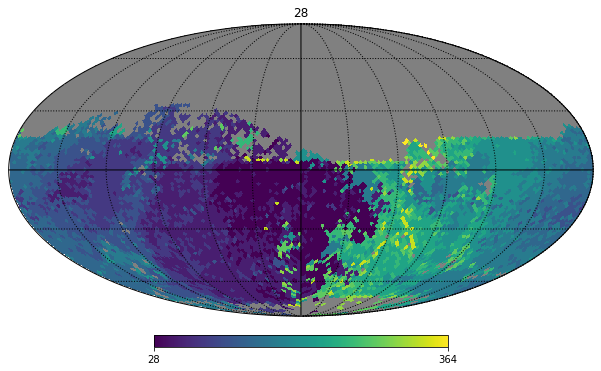

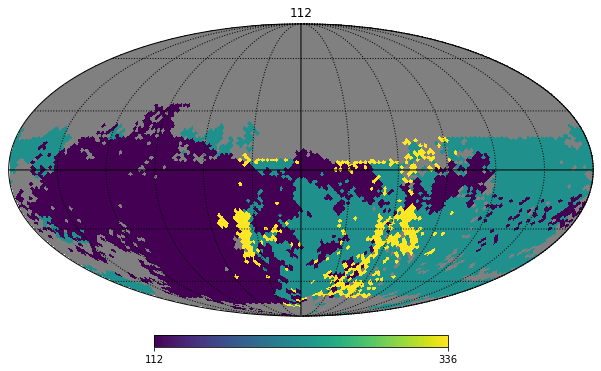

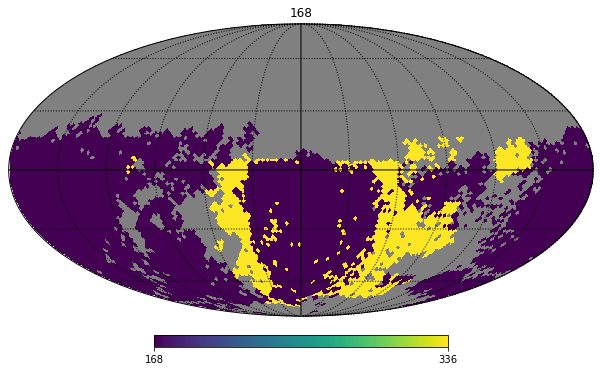

In [23]:
for template_timescale in tscales:

    metric_plot = metric_dict[str(template_timescale)]["doAllTemplateMetrics_Night"]["r"]
    hp.mollview(metric_plot, title=template_timescale)
    hp.graticule()
    

22620.642325731365


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_72923/725673439.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])


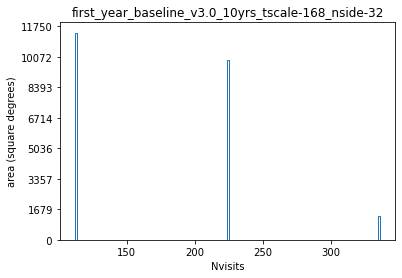

In [24]:
# manually plot the histograms

metric_plot = metric_dict["112"]["doAllTemplateMetrics_Night"]["r"]

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])
# bins = "auto"
bins = 200
pix_area = hp.pixelfunc.nside2pixarea(nside, degrees=True) # square degrees
        
n,b,p = ax1.hist(metric_plot, bins = bins, histtype = "step")

# ax1.axvline(np.median(data),c="C{}".format(i))

# total area
print(sum(n)*pix_area)

# scale the y axis to get sky area
y_vals = ax1.get_yticks()
ax1.set_yticklabels(['{:3.0f}'.format(x * pix_area) for x in y_vals])

ax1.set_xlabel("Nvisits")
ax1.set_ylabel("area (square degrees)")

# # ax1.set_yscale("log")
# # ax1.set_xlim(0,50)
# ax1.legend()

plt.title(metric_bundle[0].runName)

plt.show()

In [25]:
# when analysing the baseline metrics, do not sum (the cumulative will not work)

# Run the full remove template code on all date ranges

In [26]:
tscales

[28, 112, 168]

In [27]:
# nside = 256
# save_dir = "remove_no_template_results"
# templates_fname = "{}/{}_{}_{}.json".format(save_dir,opsdb.split(".db")[0],nside,"-".join(str(x) for x in tscales))
# templates_fname,os.path.isfile(templates_fname)

In [28]:
template_col = "npix_template"

start = time.time()

print(opsdb,nside)

_runName = "{}_nside-{}".format(runName,nside).replace(".","_")
templates_fname = "{}/{}_tscales-{}.json".format(save_dir,_runName,"-".join(str(x) for x in tscales))


if os.path.isfile(templates_fname):
    print("load {}".format(templates_fname))
    template_visits = json.load( open(templates_fname) )
else:
    template_visits = {}
    for template_timescale in tscales:

        n_visits = []
        obsIds = []
        template_frac_list = []

        template_nights = template_timescales[str(template_timescale)]

        for i in range(1,len(template_nights)):
            t_data = template_nights[i] # query all visits up to the time when we must consider new template generation
            t_template = template_nights[i-1] # this is the last date at which templates were generated
            # select visits in chunk from original year 1 database
            data = maf.getSimData(opsdb, None, None,
                                  full_sql_query='select * from observations where night <= {}{};'.format(t_data,sqlDD))

            # convert to dataframe
            df = pd.DataFrame(data)

            # add new column
            df[template_col] = np.nan

            # write the dataframe to recarray
            data = df.to_records(index=False)
            
            # remove templates without visits
            data_w_templates = remove_no_templates(data, night_template_min = t_template, nside = nside,
                                                  template_col = template_col)
            n = data_w_templates.size
            n_visits.append(n)
            obsIds += list(data_w_templates["observationId"])
            print(t_data,t_template,n,data.size,len(obsIds))

#         # get the ids of each observation that has a template and can be kept
#         # store the obsids of each timescale
#         template_visits[str(template_timescale)] = {"n_visits":np.array(n_visits).tolist(),
#                                               "template_nights":np.array(template_nights[1:]).tolist(),
#                                               "obsIds":np.array(obsIds).tolist()}

            data_w_templates = remove_no_templates(data, night_template_min = t_template, nside = nside)
            template_frac_list+=list(data_w_templates[template_col])
                                
        # store the obsids and template_fraction of each timescale
        template_visits[str(template_timescale)] = {"n_visits":np.array(n_visits).tolist(),
                                              "template_nights":np.array(template_nights[1:]).tolist(),
                                              "npix_template":np.array(template_frac_list).tolist(),
                                                    "obsIds":np.array(obsIds).tolist()}
        
        print(template_frac_list[:50])
        print(sum(n_visits),len(template_frac_list))
#         break

    end = time.time()
    dt = end-start
    print("{}s ({:2f}min or {:2f}hrs)".format(dt,dt/60,dt/60/60))

    json.dump( template_visits, open(templates_fname, 'w' ) )

first_year_baseline_v3.0_10yrs.db 32
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0
28 0 0 19937 0
night_template_min = 0, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 0
night_template_min = 28, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 28
56 28 4247 34634 4247
night_template_min = 28, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 28
night_template_min = 56, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 56
84 56 8006 53126 12253
night_template_min = 56, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 56
night_template_min = 84, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 84
112 84 7522 69176 19775
night_template_min = 84, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 84
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112
140 112 10284 88795 30059
night_template_min = 112, seeing_ratio = 2.0, m5_range = 0.5
night_template_min = 112
night_templat

In [29]:
# save the redacted database for each timescale
# select visits in chunk from original year 1 database
df_data = df_year1.copy()
print(len(df_data))

for template_timescale in tscales:
    
    df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(template_timescale)]["obsIds"])]
    print(template_timescale, len(df_data_w_templates))
    
    # Insert a column for fraction template coverage
    # keep only visits with a template fractional coverage greater than some number (>0.9?)
    df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]
    
    fname = "{}/visit_cut_t-{}d_nside-{}.db".format(save_dir,template_timescale,nside)
    print(fname)

    # open up a connection to a new database
    conn = sqlite3.connect(fname)
    # save reduced visit dataframe to sql
    df_data_w_templates.to_sql('observations', conn, index=False, if_exists='replace')
    conn.close()

216378
28 114034
remove_no_template_results_32_test2_noDD/visit_cut_t-28d_nside-32.db


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_72923/3609334197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]


112 74343
remove_no_template_results_32_test2_noDD/visit_cut_t-112d_nside-32.db


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_72923/3609334197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]


168 57795
remove_no_template_results_32_test2_noDD/visit_cut_t-168d_nside-32.db


/var/folders/6r/3460lbq91j9402dmmk71v61m0000gt/T/ipykernel_72923/3609334197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_w_templates.loc[:,"npix_template"] = template_visits[str(template_timescale)]["npix_template"]


In [30]:
template_visits.keys()

dict_keys(['28', '112', '168'])

28 0.4299857937106477
112 0.4230257051773536
168 0.4250540704213167


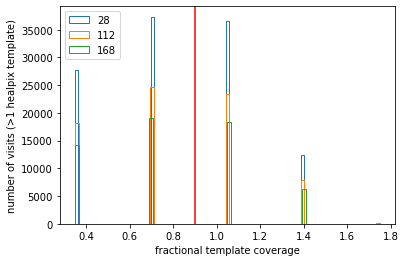

In [31]:
x_plot = "npix_template"
tscale = 112

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# ax1.hist(template_visits["112"][x_plot],bins = "auto")

for tscale in tscales:
    x = template_visits[str(tscale)][x_plot]/n_pix
    ax1.hist(x,bins = "auto", histtype = "step", label = tscale)
    print(tscale,len(x[x>=frac])/len(x))

ax1.axvline(frac,c="r")

ax1.set_xlabel("fractional template coverage")
ax1.set_ylabel("number of visits (>1 healpix template)")
ax1.legend(loc = "upper left")

fname = "npix_template_hist.png"
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")
    
plt.show()

In [32]:
template_visits.keys()

dict_keys(['28', '112', '168'])

In [33]:
df_data_w_templates

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id,npix_template
111987,111987,122.857107,-19.753221,60386.994016,60387.022645,30.0,i,196.136594,196.136594,2,...,357.742854,-0.978282,98.044864,29.243533,54.528753,122.378678,55.255662,65.047562,0,2.0
111988,111988,121.806240,-16.793070,60386.994473,60387.022645,30.0,i,203.260475,203.260475,2,...,357.743271,-0.978102,98.048790,29.243187,51.434034,122.087094,55.257323,56.858696,0,2.0
111989,111989,124.724531,-17.182173,60386.994922,60387.022645,30.0,i,199.309465,199.309465,2,...,357.743681,-0.977924,98.052649,29.242844,53.087134,124.720639,55.258956,62.334817,0,2.0
111990,111990,125.831336,-20.122816,60386.995375,60387.022645,30.0,i,192.767297,192.767297,2,...,357.744095,-0.977745,98.056550,29.242494,56.162493,124.977231,55.260607,70.103810,0,2.0
111991,111991,126.981477,-23.057890,60386.995832,60387.022645,30.0,i,185.938461,185.938461,2,...,357.744512,-0.977564,98.060483,29.242137,59.242827,125.115694,55.262271,78.332869,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216367,216367,321.835622,-17.700427,60583.100835,60583.135416,30.0,u,200.510258,200.510258,1,...,186.500097,-2.808967,160.521681,11.202930,160.789717,131.441201,16.331052,23.610469,0,4.0
216368,216368,325.039530,-17.773464,60583.101264,60583.135416,30.0,u,191.355930,191.355930,1,...,186.500484,-2.809133,160.528396,11.200622,163.638125,134.252427,16.327442,32.005494,0,3.0
216369,216369,317.893060,-22.770290,60583.101850,60583.135416,30.0,u,222.678096,222.678096,1,...,186.501014,-2.809361,160.537579,11.197468,155.497469,126.155108,16.322505,2.511699,0,1.0
216373,216373,313.150514,-33.400167,60583.103719,60583.135416,30.0,u,263.368952,263.368952,1,...,186.502703,-2.810087,160.566853,11.187431,146.491284,118.081577,16.306773,-33.962407,0,1.0


In [34]:
len(template_visits[str(template_timescale)]["obsIds"])

57795

In [35]:
len(df_data_w_templates),len(template_visits[str(template_timescale)]["npix_template"])

(57795, 57795)

In [36]:
df_data_w_templates[~pd.isnull(df_data_w_templates["npix_template"])]

,observationId,fieldRA,fieldDec,observationStartMJD,flush_by_mjd,visitExposureTime,filter,rotSkyPos,rotSkyPos_desired,numExposures,...,sunRA,sunDec,moonRA,moonDec,moonDistance,solarElong,moonPhase,cummTelAz,scripted_id,npix_template
111987,111987,122.857107,-19.753221,60386.994016,60387.022645,30.0,i,196.136594,196.136594,2,...,357.742854,-0.978282,98.044864,29.243533,54.528753,122.378678,55.255662,65.047562,0,2.0
111988,111988,121.806240,-16.793070,60386.994473,60387.022645,30.0,i,203.260475,203.260475,2,...,357.743271,-0.978102,98.048790,29.243187,51.434034,122.087094,55.257323,56.858696,0,2.0
111989,111989,124.724531,-17.182173,60386.994922,60387.022645,30.0,i,199.309465,199.309465,2,...,357.743681,-0.977924,98.052649,29.242844,53.087134,124.720639,55.258956,62.334817,0,2.0
111990,111990,125.831336,-20.122816,60386.995375,60387.022645,30.0,i,192.767297,192.767297,2,...,357.744095,-0.977745,98.056550,29.242494,56.162493,124.977231,55.260607,70.103810,0,2.0
111991,111991,126.981477,-23.057890,60386.995832,60387.022645,30.0,i,185.938461,185.938461,2,...,357.744512,-0.977564,98.060483,29.242137,59.242827,125.115694,55.262271,78.332869,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216367,216367,321.835622,-17.700427,60583.100835,60583.135416,30.0,u,200.510258,200.510258,1,...,186.500097,-2.808967,160.521681,11.202930,160.789717,131.441201,16.331052,23.610469,0,4.0
216368,216368,325.039530,-17.773464,60583.101264,60583.135416,30.0,u,191.355930,191.355930,1,...,186.500484,-2.809133,160.528396,11.200622,163.638125,134.252427,16.327442,32.005494,0,3.0
216369,216369,317.893060,-22.770290,60583.101850,60583.135416,30.0,u,222.678096,222.678096,1,...,186.501014,-2.809361,160.537579,11.197468,155.497469,126.155108,16.322505,2.511699,0,1.0
216373,216373,313.150514,-33.400167,60583.103719,60583.135416,30.0,u,263.368952,263.368952,1,...,186.502703,-2.810087,160.566853,11.187431,146.491284,118.081577,16.306773,-33.962407,0,1.0


In [37]:
### TODO
# create a metric that uses npix_template to filter visits
# Count total visits and pairs
# Count cumulative visits and pairs

# The following figures show an overestimate (visits that have >=1 healpix with template)

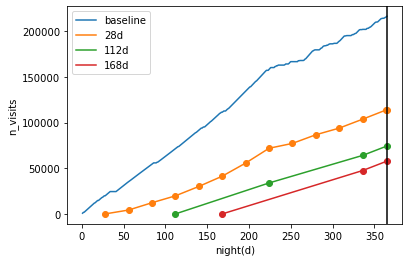

In [38]:
# plot the (cumulative) number of visits with templates as a function of survey night
# different lines show the effect of generating templates on different timescales

x_plot = "night(d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# plot year 1 baseline
counts, bins = np.histogram(df_year1["night"], bins=nights)
# ax1.plot(bins[1:], counts.cumsum(), label = year1_fname)
ax1.plot(bins[1:], counts.cumsum(), label = "baseline")
# ax1.axhline(len(df_year1))

# plot each template generation timescale
for i,t in enumerate(tscales):
    
    ax1.plot(np.array(template_visits[str(t)]["template_nights"]),
             np.array(template_visits[str(t)]["n_visits"]).cumsum(),
             label = "{}d".format(t),c="C{}".format(i+1))
    ax1.scatter(np.array(template_visits[str(t)]["template_nights"]),
               np.array(template_visits[str(t)]["n_visits"]).cumsum(),
               c="C{}".format(i+1))

ax1.legend()
ax1.axvline(night_max,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

# plt.title("cumulative visits for different template generation timescales")

fname = "n_visits_by_night.png"
plt.savefig(fname, facecolor="w", transparent=True, bbox_inches="tight")

plt.show()

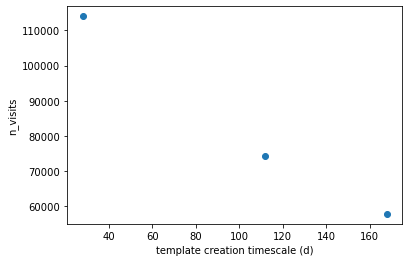

In [39]:
# plot number of visits vs template timescale
    
x_plot = "template creation timescale (d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

ax1.scatter(tscales, [np.array(template_visits[str(t)]["n_visits"]).cumsum()[-1] for t in tscales])

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

plt.show()

In [40]:
for t in tscales:
    print(t, template_visits[str(t)]["n_visits"][-1])

28 254
112 10284
168 10284


In [41]:
for t in tscales:
    print(t, sum(template_visits[str(t)]["n_visits"]))

28 114034
112 74343
168 57795


# mask the visit database to get a more realistic number of useful visits
This will be an underestimate compared to analysing each healpixel directly

In [42]:
n_pix

2.8595474464675097

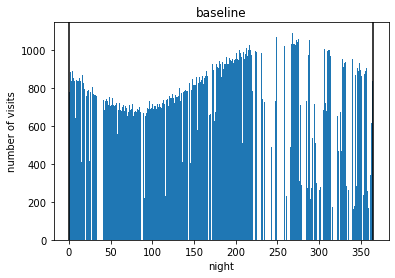

53629864


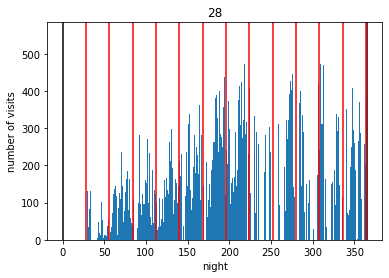

34964016


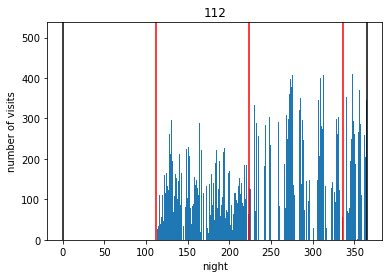

27178248


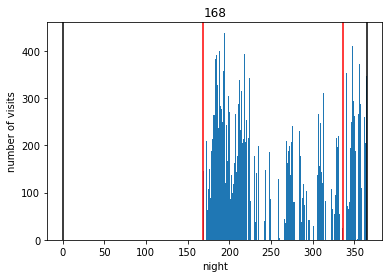

In [43]:
# distribution of visits with templates by night
x_plot = "night"
bins = nights
    
for i,tscale in enumerate(["baseline"] + tscales):
    
    if tscale!="baseline":
        df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(tscale)]["obsIds"])]
        print(sys.getsizeof(df_data_w_templates))
        df_plot = df_data_w_templates
        # mask based on some fraction
        mask = template_visits[str(tscale)]["npix_template"]>=(frac*n_pix)
        df_plot = df_plot[mask]
    else: # use the baseline
        df_plot = df_year1

    fig = plt.figure()
    gs = gridspec.GridSpec(1,1)
    ax1 = plt.subplot(gs[0,0])

    ax1.hist(df_plot[x_plot],bins=bins)

    ax1.axvline(0,c="k")
    ax1.axvline(night_max,c="k")

    if tscale!="baseline":
        for t in np.arange(tscale,night_max+tscale,tscale):
            if t>night_max:
                continue
            ax1.axvline(t,c="r", label = "template")

    ax1.set_xlabel(x_plot)
    ax1.set_ylabel("number of visits")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
#     ax1.legend(by_label.values(), by_label.keys())

    plt.title(tscale)

    plt.show()

In [44]:
# repeat the above plot but with cumsum to get total visits as function of time

216378
114034
[ 28  56  84 112 140 168 196 224 252 280 308 336 364 365] 14
[    0   950  3901  6913 10800 15826 22146 29015 31699 35906 39102 44102
 48662 49033] 14
74343
[112 224 336 365] 4
[    0 13093 26543 31449] 4
57795
[168 336 365] 3
[    0 19660 24566] 3


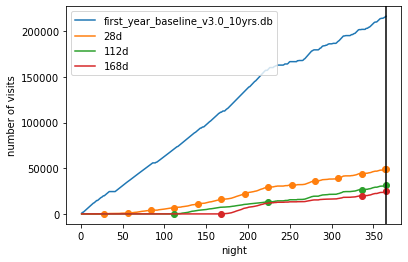

In [45]:
# distribution of visits with templates by night

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])
    
total_counts = {}

# plot year 1 baseline
counts, bins = np.histogram(df_year1["night"], bins=nights)
ax1.plot(bins[1:], counts.cumsum(), label = year1_fname)
print(len(df_year1))

total_counts["baseline"] = counts.cumsum()[-1]

for i,tscale in enumerate(tscales):
    
    df_data_w_templates = df_data[np.isin(df_data["observationId"],template_visits[str(tscale)]["obsIds"])]
#     print(sys.getsizeof(df_data_w_templates))
    print(len(df_data_w_templates))
    
    x_plot = "night"
    df_plot = df_data_w_templates
    bins = nights

    # mask based on some fraction
    mask = template_visits[str(tscale)]["npix_template"]>=(frac*n_pix)
    df_plot = df_plot[mask]

#     ax1.plot(df_plot[x_plot],
#              df_plot[x_plot].cumsum(),
#              label = "{}d".format(tscale))#,c="C{}".format(i+1))
    
    counts, bins = np.histogram(df_plot[x_plot], bins=nights)
    ax1.plot(bins[1:], counts.cumsum(), label = "{}d".format(tscale),
            c = "C{}".format(i+1))
    
    template_nights = np.array(template_visits[str(tscale)]["template_nights"])
    template_night_count = counts.cumsum()[np.isin(bins[1:],template_nights)]
    print(template_nights,len(template_nights))
    print(template_night_count,len(template_night_count))
    ax1.scatter(template_nights,template_night_count,c = "C{}".format(i+1))
    
#     for t in np.arange(tscale,365+tscale,tscale):
#         if t>365:
#             continue
#         ax1.axvline(t,c="r", label = "template")

    total_counts[str(tscale)] = counts.cumsum()[-1]


# ax1.axvline(0,c="k")
ax1.axvline(night_max,c="k")

ax1.set_xlabel(x_plot)
ax1.set_ylabel("number of visits")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax1.legend(by_label.values(), by_label.keys())

plt.show()

In [46]:
total_counts

{'baseline': 216378, '28': 49033, '112': 31449, '168': 24566}

In [47]:
total_area = {}
for x in total_counts.keys():
    total_area[x] = total_counts[x]*lsst_footprint
total_area

{'baseline': 2077228.7999999998,
 '28': 470716.8,
 '112': 301910.39999999997,
 '168': 235833.6}

In [48]:
# compare this number to the analysis notebook

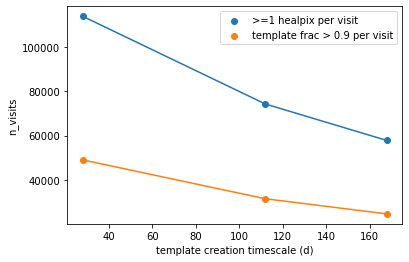

In [49]:
# plot number of visits vs template timescale
    
x_plot = "template creation timescale (d)"
y_plot = "n_visits"

fig = plt.figure()
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

counts1 = np.array([sum(template_visits[str(t)]["n_visits"]) for t in tscales])
ax1.plot(tscales, counts1)
ax1.scatter(tscales, counts1, label = ">=1 healpix per visit")

counts2 = np.array([total_counts[str(t)] for t in tscales])
ax1.plot(tscales, counts2)
ax1.scatter(tscales, counts2, label = "template frac > {} per visit".format(frac))

ax1.set_xlabel(x_plot)
ax1.set_ylabel(y_plot)

ax1.legend()

plt.show()

In [50]:
# compare the fractional difference to the histogram of template fractional coverage above
counts2/counts1

array([0.42998579, 0.42302571, 0.42505407])